In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    SoftPhongShader,
    MeshRasterizer,  
    HardPhongShader,
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
def get_path(func):  
    if type(func).__name__ == 'function' : 
        return func.__code__.co_filename
    else: 
        raise ValueError("'func' must be a function") 
print(now_str())
print(torch.__version__)
print(torch.version.cuda)
print(get_path(load_obj))

[04/30 00:02:10]
1.4.0
9.2
d:\1_projects\200323_pytorch3dstart\pytorch3d\io\obj_io.py


In [2]:
print('torch.cuda.is_available():',torch.cuda.is_available())

device = torch.device("cuda:0")
torch.cuda.set_device(device)
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
----- torch.cuda.empty_cache() -----
torch.cuda.memory_reserved(): 0.00 Mb
torch.cuda.memory_allocated(): 0.00 Mb
torch.cuda.memory_cached(): 0.00 Mb


dverts: (4, 3), min=0.10, max=0.10


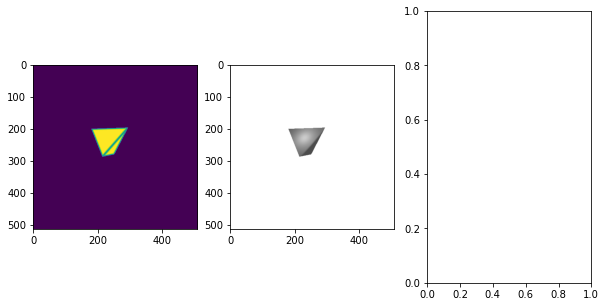

In [41]:
image_size = 512

distance = 3   # distance from camera to the object
elevation = 0.0   # angle of elevation in degrees
azimuth = 150.0  # No rotation so the camera is positioned on the +Z axis. 
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=image_size, 
    blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=1, 
)
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
a_diffuse = 0.5
a_ambient = 0.3
s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(device)
d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(device)
a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(device)
lights.specular_color = s
lights.diffuse_color = d
lights.ambient_color = a
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)
texture_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
#     shader=TexturedSoftPhongShader(device=device, blend_params=blend_params, lights=lights)
    shader=SoftPhongShader(device=device, lights=lights, blend_params=blend_params)
)

#in_dir = './1_data/cow_mesh'
in_dir = './2_data'
s = 32
texturemap_shape = (s, s, 1)
np.random.seed(image_size * s)
texturemap_np = np.random.rand(texturemap_shape[0], texturemap_shape[1], 3).astype(np.float32)*0
# texturemap_np = Image.open('./1_data/cow_mesh' + '/cow_texture.png')
# texturemap_np = texturemap_np.convert('RGB')
texturemap_np = np.asarray(texturemap_np).astype(np.float32)
texturemap_np = cv2.resize(texturemap_np, (raster_settings.image_size, raster_settings.image_size), interpolation=cv2.INTER_NEAREST)
texturemap_np = np.expand_dims(texturemap_np, axis=0)
# texturemap_np /= 255.0
texture_map_torch = torch.from_numpy(texturemap_np).to(device)
texture_map = nn.Parameter(texture_map_torch, requires_grad=False)

#mesh_paths = in_dir + '/cow.obj'
mesh_paths = in_dir + '/tetrahedron.obj'
verts, faces, aux = load_obj(mesh_paths)
faces_idx = faces.verts_idx

# Initialize each vertex to be white in color.
verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

# for using texturemap
#textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs, verts_rgb=verts_rgb.to(device)).to(device

# for no texturemap
textures = Textures(verts_rgb=verts_rgb.to(device)).to(device)

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces_idx.to(device)], 
    textures=textures
)

# deform mesh
scale = 0.0
target_vertex = -1
verts = mesh.verts_packed().detach().cpu().numpy()
dverts_target = np.zeros((verts.shape[0], 3)).astype(np.float32)
# dverts_target = (np.random.rand(verts.shape[0], 3).astype(np.float32) - 0.5)*scale
dverts_target = dverts_target.astype(np.float32)
dverts_target = dverts_target + np.array([0.1, 0.1, 0.1]).astype(np.float32)
print('dverts: {}, min={:.2f}, max={:.2f}'.format(dverts_target.shape, np.min(dverts_target), np.max(dverts_target)))
dverts_target = torch.from_numpy(dverts_target).to(device)
mesh_target = mesh.clone()
mesh_target = mesh_target.offset_verts(dverts_target)
silhouette = silhouette_renderer(meshes_world=mesh_target)
# image_rendered, prob = texture_renderer(meshes_world=mesh_target)
image_rendered = texture_renderer(meshes_world=mesh_target)

silhouette = silhouette.cpu().numpy().squeeze()
image_rendered = image_rendered.detach().cpu().numpy().squeeze()

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(silhouette[..., 3])
ax[1].imshow(image_rendered[..., :3])
# mesh_texturemaps = mesh_target.textures._maps_padded.detach().squeeze().cpu().numpy()
# ax[2].imshow(mesh_texturemaps, vmin=0, vmax=255)
plt.show()

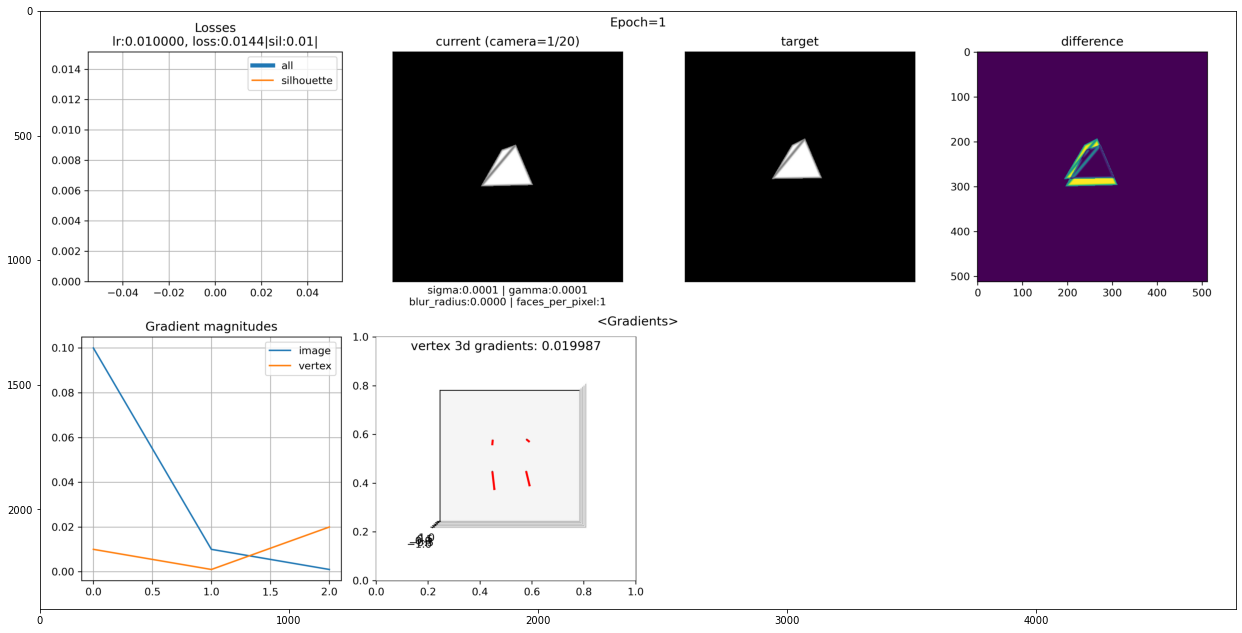

In [59]:
import math
class GaussianLayer(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        
        self.convs = {}
        kernel_size = 3
        sigma = 1
        self.convs[4] = self._get_gaussian_conv2d(kernel_size, sigma, channels=4)
        self.convs[3] = self._get_gaussian_conv2d(kernel_size, sigma, channels=3)
        self.convs[1] = self._get_gaussian_conv2d(kernel_size, sigma, channels=1)

        # Given groups=3, weight of size 3 1 3 3, expected input[1, 512, 512, 4] to have 3 channels, but got 512 channels instead
        
    def forward(self, x, kernel_size, sigma):
        if kernel_size < 3.0:
            return x

        channels = x.shape[-1]
        gaussian_kernel = self._generate_gaussian_kernel(kernel_size=kernel_size, sigma=sigma, channels=channels)
        self.convs[channels].weight.data = gaussian_kernel
        self.convs[channels].padding = int(kernel_size/2)
        
        x = x.transpose(3, 1)
        # gaussian_kernel: (channels, batch, w, h)=(4, 1, 3, 3)
        # x: (batch, channels, w, h)=(1, 4, 512, 512)
        out = self.convs[channels](x)
        out = out.transpose(3, 1)
        return out
    
    def _generate_gaussian_kernel(self, kernel_size, sigma, channels=4):
        # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
        x_cord = torch.arange(kernel_size)
        x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1)

        mean = (kernel_size - 1)/2.
        variance = sigma**2.

        # Calculate the 2-dimensional gaussian kernel which is
        # the product of two gaussian distributions for two different
        # variables (in this case called x and y)
        gaussian_kernel = (1./(2.*math.pi*variance)) * torch.exp(-torch.sum((xy_grid - mean)**2., dim=-1) / (2*variance + 1e-8))
        
#         gaussian_kernel = torch.sum((xy_grid - mean)**2, dim=-1)
        # Make sure sum of values in gaussian kernel equals 1.
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
        # Reshape to 2d depthwise convolutional weight
        gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1).to(self.device)
        return gaussian_kernel
    
    def _get_gaussian_conv2d(self, kernel_size, sigma, channels=4):
        gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, stride=1, padding=int(kernel_size/2), groups=channels, bias=False).to(self.device)
        gaussian_kernel = self._generate_gaussian_kernel(kernel_size=kernel_size, sigma=sigma, channels=channels)
        gaussian_filter.weight.data = gaussian_kernel
        gaussian_filter.weight.requires_grad = False
        return gaussian_filter
    
    
    
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()
        
        self.device = device
        self.n_cams = kwargs.get('n_cams', None)
        self.cameras = None
        self.texture_maps = kwargs.get('texture_maps', None)
        self.mesh = kwargs.get('mesh', None)
        self.mesh_target = kwargs.get('mesh_target', None)
        self.target_images = None
        
        self.batch_size = kwargs.get('batch_size', None)
        self.n_batch = int(self.n_cams / self.batch_size)
        self.camera_batches = []
        
        self.renderer = self._init_renderer()
        self.target_image_batches, self.target_silhouette_batches = self._init_target_images()
        self.dverts = torch.from_numpy(np.zeros((self.mesh.verts_packed().shape), dtype=np.float32)).to(self.device)
        self.dverts = nn.Parameter(self.dverts, requires_grad=True)
#         self.center_offset = torch.from_numpy(np.zeros(3, dtype=np.float32)).to(self.device)
#         self.center_offset = nn.Parameter(self.center_offset, requires_grad=True)
        
#         self.gaussian = GaussianLayer(self.device)
        
    def forward(self, batch_idx, kernel_size, sigma, raster_settings, blend_params):
        # ==================================================================================== #
        # minibatch training
        i0 = batch_idx*self.batch_size
        i1 = i0 + self.batch_size
        
        # batch preparation
        mesh_deformed = self.mesh.offset_verts(self.dverts)
        meshes = mesh_deformed.extend(self.batch_size)
        cam_batch = self.camera_batches[batch_idx]
        
        # render
        images = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=raster_settings, blend_params=blend_params)
        silhouettes = images[..., 3]
        images = images[..., :3]
        #silhouettes = self.sil_renderer(meshes_world=meshes, cameras=cam_batch, texture_maps=model.mesh.textures._maps_padded.clone(), raster_settings=raster_settings, blend_params=blend_params)
        #silhouettes = images.clone().detach().squeeze()[..., 3]
        
        # blur if needed
        if kernel_size > 1.0:
#             image = self.gaussian(image, kernel_size=kernel_size, sigma=sigma)
#             target_image = self.gaussian(self.target_image, kernel_size=kernel_size, sigma=sigma)
#             target_silhouette = self.gaussian(self.target_silhouette.unsqueeze(-1).unsqueeze(0), kernel_size=kernel_size, sigma=sigma)
            target_images = self.target_image_batches[batch_idx]
            target_silhouettes = self.target_silhouette_batches[batch_idx]
        else:
            target_images = self.target_image_batches[batch_idx]
            target_silhouettes = self.target_silhouette_batches[batch_idx]
            
        # losses
        # loss_pixels = torch.mean(torch.abs(images - target_images))
        # loss_silhouettes = 0.5*self._iou(silhouettes, target_silhouettes)
        loss_silhouettes = torch.mean(torch.abs(silhouettes - target_silhouettes))
        loss_pixels = None
        loss = loss_silhouettes
        loss_dict = {'all': loss, 'pixel': loss_pixels, 'silhouette': loss_silhouettes}
        image_dict = {'images': images, 'silhouettes': silhouettes, 'target_images': target_images, 'target_silhouettes': target_silhouettes}
        return image_dict, loss_dict
    
    def _iou(self, S1, S2):
        S1S2 = torch.mul(S1, S2)
        return torch.mean(1.0 - torch.sum(torch.abs(S1S2)) / torch.sum(torch.abs(S1+S2-S1S2)))
    
    def _init_target_images(self):
        meshes = self.mesh_target.extend(self.batch_size)
        
        target_image_batches = []
        target_sil_batches = []
        for batch_idx in range(self.n_batch):
            cam_batch = self.camera_batches[batch_idx]
            target_images = self.renderer(meshes_world=meshes, cameras=cam_batch)
            silhouette_images = target_images[..., 3].clone()
            target_images = target_images[..., :3]
            target_image_batches.append(target_images)
        
            # silhouette_images = self.sil_renderer(meshes_world=meshes, cameras=cam_batch)
            # silhouette_images = silhouette_images[..., 3]
            target_sil_batches.append(silhouette_images)
            
        return target_image_batches, target_sil_batches
        
    def _init_cameras(self):
        d_angle = 360.0 / self.n_cams
        camera_batches = []
        for batch_idx in range(self.n_batch):
            i0 = batch_idx*self.batch_size
            i1 = i0 + self.batch_size
            
            R_batch = torch.empty([batch_size, 3, 3])
            T_batch = torch.empty([batch_size, 3])
            for i in range(self.batch_size):
                distance = 3
                elevation = 0.0
                azimuth = -150 + d_angle * (i0 + i)
                Ri, Ti = look_at_view_transform(distance, elevation, azimuth, device=self.device)
                R_batch[i] = Ri.squeeze()
                T_batch[i] = Ti.squeeze()
            cam_batch = OpenGLPerspectiveCameras(device=self.device, R=R_batch, T=T_batch)
            camera_batches.append(cam_batch)
        return camera_batches
            
    def _init_renderer(self):
        global image_size
        self.camera_batches = self._init_cameras()
        
        blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        raster_settings = RasterizationSettings(
            image_size=image_size, 
            blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
            faces_per_pixel=1, 
        )
        lights = PointLights(device=self.device, location=((2.0, 2.0, -2.0),)).to(self.device)
        a_diffuse = 0.5
        a_ambient = 0.3
        s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(self.device)
        d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(self.device)
        a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(self.device)
        lights.specular_color = s
        lights.diffuse_color = d
        lights.ambient_color = a
        
        rasterizer = MeshRasterizer(cameras=self.cameras, raster_settings=raster_settings)
        
        texture_renderer = MeshRenderer(
            rasterizer=rasterizer,
#             shader=TexturedSoftPhongShader(device=self.device, cameras=None, blend_params=blend_params, lights=lights),
            shader=SoftPhongShader(device=self.device, cameras=None, lights=lights, blend_params=blend_params)
        )
            
#         silhouette_renderer = MeshRenderer(
#             rasterizer=rasterizer,
#             shader=SoftSilhouetteShader(blend_params=blend_params)
#         )
        
        return texture_renderer

def render_plots(out_dir, e, losses, lr, image_curr, target_image, texture_map, model, raster_settings, blend_params):
    fig, ax = plt.subplots(1, 6, figsize=(24, 4), tight_layout=True)
    ax[5].grid('off')
    ax[5].axis('off')
    loss_all = losses['all']
    loss_pixel = losses['pixel']
    ax[0].plot(loss_all, linewidth=4)
    ax[0].plot(loss_pixel)
    ax[0].legend(['all', 'pixel'])
    ax[0].set_title('Losses\nlr={:.6f}\n{:.4f} | {:.4f} | {:.4f}'.format(lr, loss_all[-1], loss_pixel[-1]))
    ax[0].set_ylim(bottom=0)
    ax[0].grid()
    
    sigma = blend_params.sigma
    gamma = blend_params.gamma
    blur_radius = raster_settings.blur_radius
    img_np = image_curr.detach().squeeze().cpu().numpy()
    img_cur = img_np[..., :3]
    ax[1].imshow(img_np, cmap='gray')
    ax[1].set_title('Current\n{:<13}:{:.4f}\n{:<13}:{:.4f}\n{:<13}:{:.4f}'.format('sigma', sigma, 'gamma', gamma, 'blur_radius', blur_radius))
    
    img_tar = target_image.detach().squeeze().cpu().numpy()
    ax[2].imshow(img_tar, cmap='gray')
    ax[2].set_title('Target')
    
    diff = np.clip(img_tar - img_cur, a_min=0.0, a_max=1.0)
    ax[3].imshow(diff)
    ax[3].set_title('Difference')
    
    ax[4].imshow(texture_map.detach().squeeze().cpu().numpy(), cmap='gray')
    ax[4].set_title('Texturemap')

    ax[5] = fig.add_subplot(166, projection='3d')
    # image gradient
#     grad = image_curr.grad.detach().cpu().numpy()
#     print(grad)
    # vertex gradient
    dverts = model.dverts.grad.detach().cpu().numpy()
    dverts_norm = np.linalg.norm(dverts)
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    ax[5].set_title('gradients: {:.3f}'.format(dverts_norm))
    ax[5].quiver(verts[:,0], verts[:,1], verts[:,2], dverts[:,0], dverts[:,1], dverts[:,2], length=5, lw=2, arrow_length_ratio=0.1, color='r')
    ax[5].view_init(elev=-90, azim=0)
    L = 0.75
    ax[5].set_xlim([-L, L])
    ax[5].set_ylim([-L, L])
    ax[5].set_zlim([-L, L])
    plt.suptitle('Epoch={}'.format(e))
    
    out_path = out_dir + '/plot_{}.png'.format(e)
    plt.savefig(out_path, dpi=300)
    plot_image = imageio.imread(out_path)
    plt.close('all')
    
    return plot_image

def render_plots_simple(out_dir, e, losses, lr, n_cams, cam_idx, image_curr, target_image, raster_settings, blend_params):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4), tight_layout=True)
    loss_all = losses['all']
    loss_pixel = losses['pixel']
    loss_sil = losses['silhouette']
    ax[0].plot(loss_all, linewidth=4)
    ax[0].plot(loss_pixel)
    ax[0].legend(['all', 'silhouette'])
    ax[0].set_title('Losses\nlr:{:.6f}, loss:{:.4f}|sil:{:.2f}|'.format(lr, loss_all[-1], loss_sil[-1]))
    ax[0].set_ylim(bottom=0)
    ax[0].grid()
    
    sigma = blend_params.sigma
    gamma = blend_params.gamma
    faces_per_pixel = raster_settings.faces_per_pixel
    blur_radius = raster_settings.blur_radius
    img_np = image_curr.detach().squeeze().cpu().numpy()
    if len(img_np.shape) > 2:
        img_cur = img_np[..., :3]
    else:
        img_cur = img_np
    ax[1].imshow(img_np, cmap='gray')
    ax[1].set_title('current (camera={}/{})'.format(cam_idx+1, n_cams))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xlabel('{}:{:.4f} | {}:{:.4f}\n{}:{:.4f} | {}:{}'.format('sigma', sigma, 'gamma', gamma, 'blur_radius', blur_radius,'faces_per_pixel', faces_per_pixel))
    img_tar = target_image.detach().squeeze().cpu().numpy()
    ax[2].imshow(img_tar, cmap='gray')
    ax[2].set_title('target')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    diff = np.clip(np.abs(img_tar - img_cur), a_min=0.0, a_max=1.0)
    ax[3].imshow(diff)
    ax[3].set_title('difference')
    
    plt.suptitle('Epoch={}'.format(e))
    out_path = out_dir + '/plot.png'
    plt.savefig(out_path, dpi=300)
    plot_image = imageio.imread(out_path)
    plt.close('all')
    
    return plot_image

def render_grads(out_dir, e, losses, lr, model, grads, image_grad, raster_settings, blend_params):
    keys = list(grads.keys())
    n_grads = len(keys)
    offset_i = 2
    fig, ax = plt.subplots(1, offset_i+n_grads, figsize=((offset_i+n_grads)*4, 4), tight_layout=True)
    
#     loss_all = losses['all']
#     loss_pixel = losses['pixel']
#     loss_silhouette = losses['silhouette']
    
    ax[1] = fig.add_subplot(1, (offset_i+n_grads), offset_i, projection='3d')
    dverts_grad = model.dverts.grad.detach().cpu().numpy()
    dverts_norm = np.linalg.norm(dverts_grad)
    dverts = dverts_grad / dverts_norm * 0.1
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    ax[1].set_title('vertex 3d gradients: {:.6f}'.format(dverts_norm))
    ax[1].quiver(verts[:,0], verts[:,1], verts[:,2], dverts[:,0], dverts[:,1], dverts[:,2], length=5, lw=2, arrow_length_ratio=0.1, color='r')
    ax[1].scatter(verts[:,0], verts[:,1], verts[:,2], c='k', s=0.1)
    ax[1].view_init(elev=-90, azim=90)
    L = 1.2
    ax[1].set_xlim([-L, L])
    ax[1].set_ylim([-L, L])
    ax[1].set_zlim([-L, L])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    if image_grad is not None:
        image_grad = image_grad.detach().squeeze().cpu().numpy()
        max_0 = np.max(image_grad, axis=0)
        max_1 = np.max(max_0, axis=0)
        min_0 = np.min(image_grad, axis=0)
        min_1 = np.min(min_0, axis=0)
        vmin = np.min(image_grad)
        vmax = np.max(image_grad)
    #     ax[2].imshow(image_grad, vmin=vmin, vmax=vmax)
    #     ax[2].set_title('min={:.3f}, max={:.3f}'.format(vmin, vmax))
    
    legends = []
    for i in range(offset_i, n_grads + offset_i):
        legends.append(keys[i-offset_i])
        vals = grads[keys[i-offset_i]]
        ax[0].plot(vals)
#         ax[i].plot(vals)
#         ax[i].set_title('gradients mag ({}): {:.6f}'.format(keys[i-offset_i], vals[-1]))
#         ax[i].grid()
        ax[i].axis('off')
    ax[0].legend(legends)
    ax[0].set_title('Gradient magnitudes')
    ax[0].grid()
    
    plt.suptitle('<Gradients>')
    out_path = out_dir + '/plot.png'
    plt.savefig(out_path, dpi=300)
    plot_image = imageio.imread(out_path)
    plt.close('all')
    
    return plot_image 

n_cams = 20
batch_size = 5
model = Model(device=device, mesh=mesh, mesh_target=mesh_target, n_cams=n_cams, batch_size=batch_size, texture_maps=texture_map)

# ================== #
# for batch_idx in range(model.n_batch):
#     images = model.target_silhouette_batches[batch_idx].squeeze().detach().cpu().numpy()
#     for i in range(model.batch_size):
#         cam_idx = batch_idx*batch_size + i
#         plt.figure(figsize=(4, 4))
#         plt.title('Camera[{}]'.format(cam_idx))
#         plt.imshow(images[i])
#         plt.show()
# ================== #

# ================== #
# test run
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
        image_size=image_size, 
        blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
        faces_per_pixel=1, 
)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
losses = {'all': [], 'pixel': [], 'silhouette': []}
kernel_size = 0
sigma = 9

optimizer.zero_grad()
image_dict, loss_dict = model(batch_idx=0, kernel_size=kernel_size, sigma=sigma, raster_settings=raster_settings, blend_params=blend_params)
for k, v in loss_dict.items():
    if v is not None:
        vv = v.detach().cpu().numpy()
        losses[k].append(vv)

loss = loss_dict['all']
image_dict['images'].retain_grad()
loss.backward()
optimizer.step()
# ================== #
    
out_dir = './6_data/output'
out_path = out_dir + '/plot.png'

is_silhouette = True
if is_silhouette:
    images = image_dict['silhouettes']
    images_target = image_dict['target_silhouettes']
    cam_idx = 0
    plot_image = render_plots_simple(out_dir, 1, losses, 0.01, model.n_cams, cam_idx, images[cam_idx], images_target[cam_idx], raster_settings=raster_settings, blend_params=blend_params)
else:
    images = image_dict['images']
    images_target = image_dict['target_images']
    cam_idx = 0
    plot_image = render_plots_simple(out_dir, 1, losses, 0.01, model.n_cams, cam_idx, images[cam_idx][..., :3], images_target[cam_idx], raster_settings=raster_settings, blend_params=blend_params)

grads = {'image': [0.1, 0.01, 0.001], 'vertex': [0.01, 0.001]}
grads['vertex'].append(np.linalg.norm(model.dverts.grad.detach().cpu().numpy()))
if image_dict['images'].grad is None:
    plot_grads = render_grads(out_dir, 1, losses, 0.01, model, grads, None, raster_settings=raster_settings, blend_params=blend_params)
else:
    image_grad = image_dict['images'].grad
    plot_grads = render_grads(out_dir, 1, losses, 0.01, model, grads, image_grad[cam_idx], raster_settings=raster_settings, blend_params=blend_params)

    

plot_image = np.hstack([plot_image, np.ones((plot_grads.shape[0], plot_grads.shape[1]-plot_image.shape[1], plot_grads.shape[2]))])

image = Image.fromarray(np.uint8(np.vstack([plot_image, plot_grads])))
plt.figure(figsize=(22, 11))
plt.imshow(image)
plt.show()

Log output: ./6_data/output/log_20200430.txt


<ipython-input-62-835dc0d6b364>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


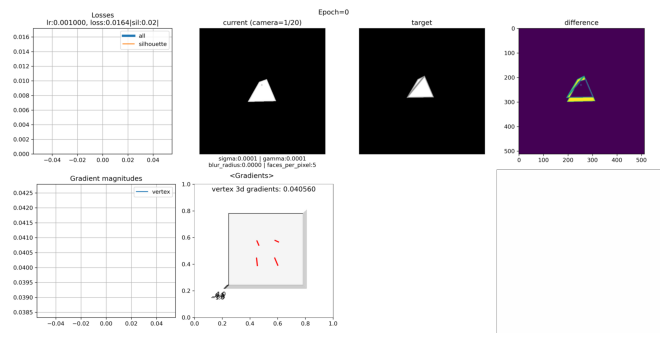

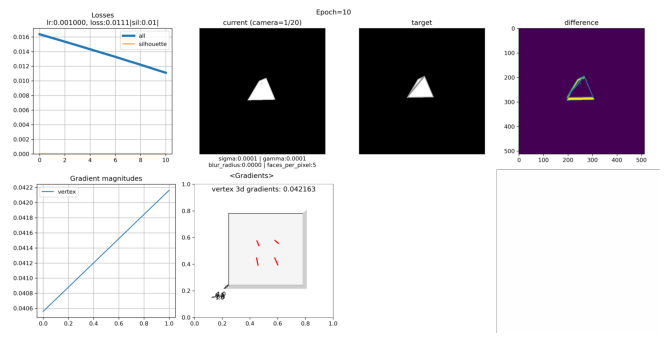

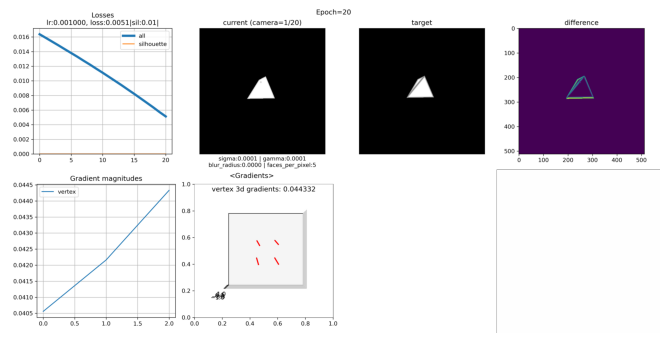

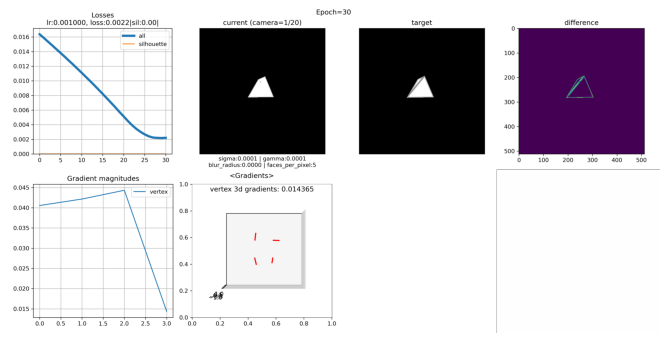

Epoch    36: reducing learning rate of group 0 to 5.0000e-04.


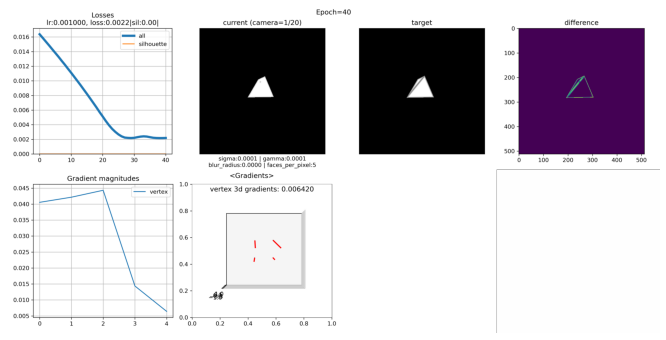

Epoch    42: reducing learning rate of group 0 to 2.5000e-04.
Epoch    48: reducing learning rate of group 0 to 1.2500e-04.


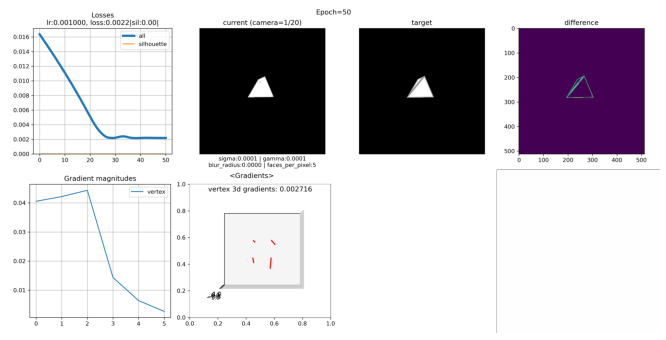

Epoch    54: reducing learning rate of group 0 to 6.2500e-05.
Epoch    60: reducing learning rate of group 0 to 3.1250e-05.


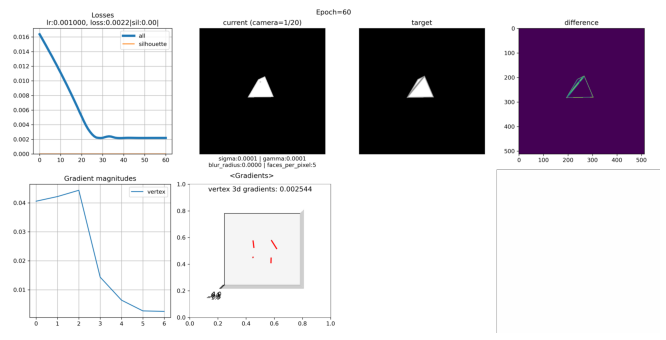

Epoch    66: reducing learning rate of group 0 to 1.5625e-05.


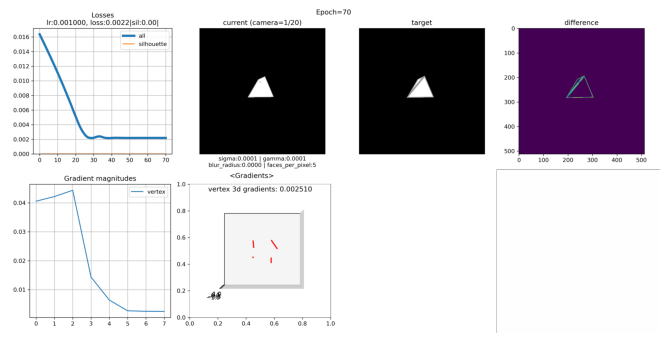

Epoch    72: reducing learning rate of group 0 to 7.8125e-06.
Epoch    78: reducing learning rate of group 0 to 3.9063e-06.


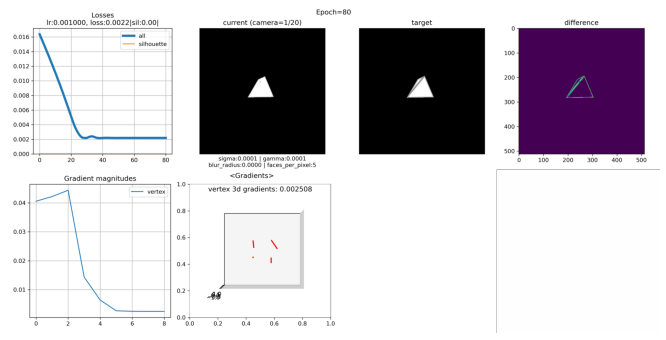

Epoch    84: reducing learning rate of group 0 to 1.9531e-06.
Epoch    90: reducing learning rate of group 0 to 9.7656e-07.


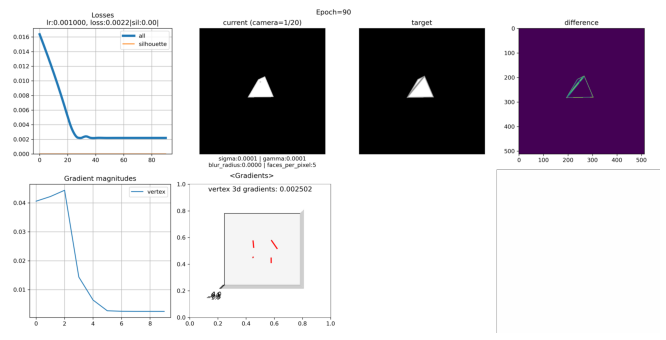

Epoch    96: reducing learning rate of group 0 to 4.8828e-07.


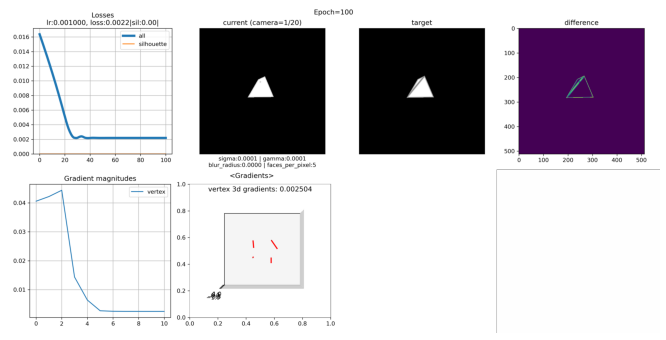

Epoch   102: reducing learning rate of group 0 to 2.4414e-07.
Epoch   108: reducing learning rate of group 0 to 1.2207e-07.


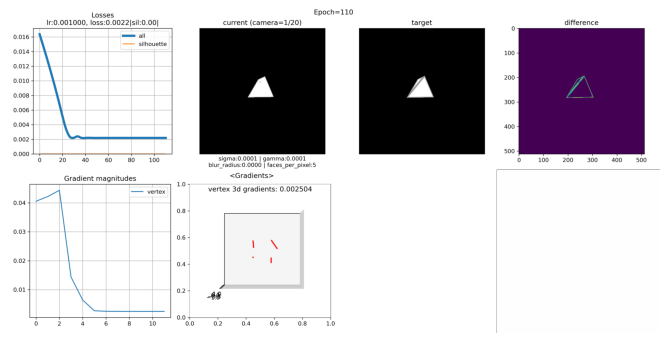

Epoch   114: reducing learning rate of group 0 to 6.1035e-08.
Epoch   120: reducing learning rate of group 0 to 3.0518e-08.


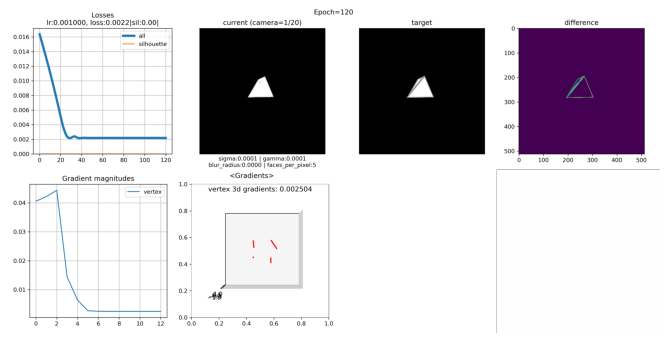

Epoch   126: reducing learning rate of group 0 to 1.5259e-08.


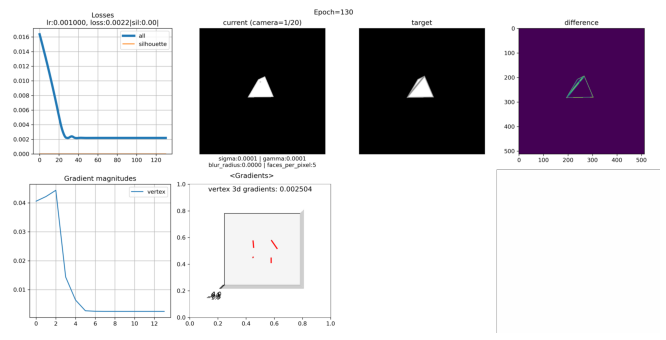

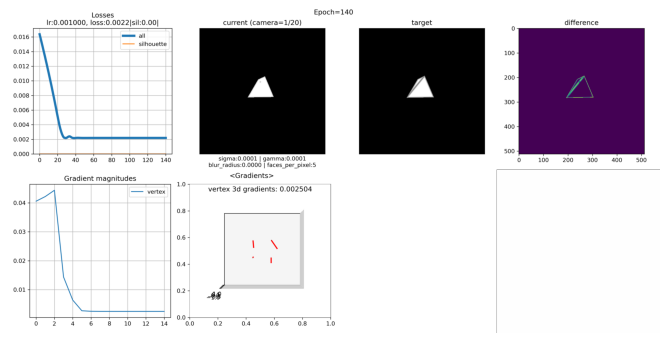

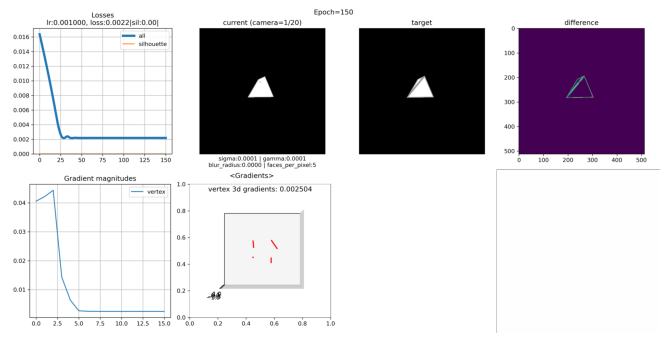

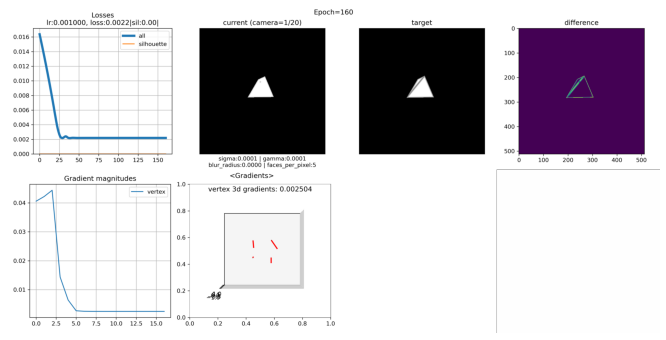

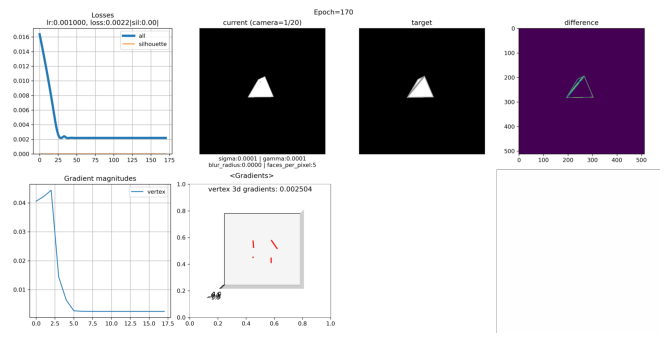

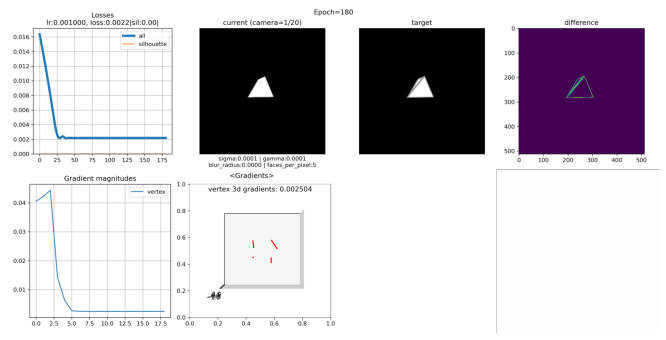

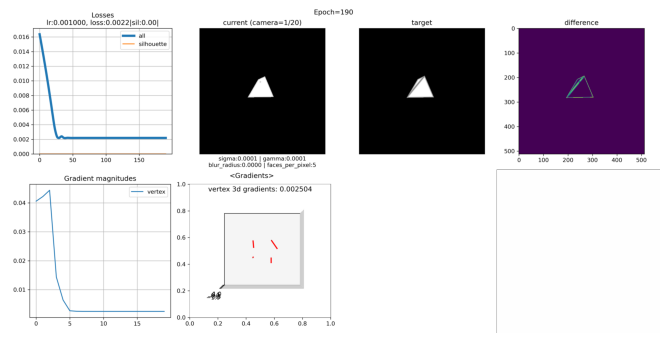

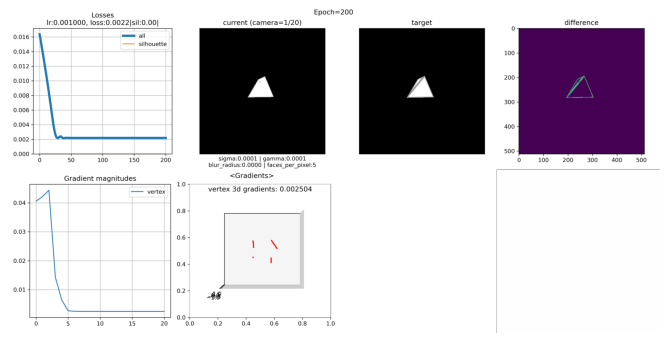

e=201. BREAK
gif saved: ./6_data/output/plots.gif


In [62]:
%matplotlib inline
from torch.optim.lr_scheduler import ReduceLROnPlateau
out_dir = './6_data/output'
gif_path = out_dir + '/plots.gif'
out_path = out_dir + '/plot.png'
n_cams = 20
batch_size = 5
model = Model(device=device, mesh=mesh, mesh_target=mesh_target, n_cams=n_cams, batch_size=batch_size, texture_maps=texture_map)
# texture_map = model.mesh.textures._maps_padded.clone()

now = datetime.now()
hour = str(now.hour)
minute = str(now.minute)
date_str = '{}{:>02}{:>02}'.format(now.year, now.month, now.day)
log_path = out_dir + '/log_{}.txt'.format(date_str)
__output_log(log_path, '========== {} Start ==========================\n'.format(date_str))
print('Log output: {}'.format(log_path))



lr = 0.001
gauss_kernel_size = 0
gauss_sigma = 64
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimize = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
loop = tqdm_notebook(range(1000000000))

cam_idx = 0
images = []
losses = {'all': [], 'pixel': [], 'silhouette': []}
grads = {'vertex': []}
latest_states = {}
sigma = 1e-4

for e in loop:
    t0 = time.time()
    show_image = (e % 10 == 0)
    lr_curr = optimizer.param_groups[0]['lr']

    optimizer.zero_grad()
    
    if e > 0 and e % 50 == 0:
        sigma = max(1e-4, sigma*0.5)
        gauss_kernel_size = max(0, int(gauss_kernel_size*0.5))
        gauss_sigma = max(1.0, gauss_sigma*0.5)
        if gauss_kernel_size % 2 == 0:
            gauss_kernel_size += 1
        
    blend_params = BlendParams(sigma=sigma, gamma=1e-4)
    raster_settings = RasterizationSettings(
                image_size=image_size, 
                blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
                faces_per_pixel=5, 
    )
    
    
    loss_dict = {'all': 0.0, 'pixel': 0.0, 'silhouette': 0.0}
    image_dict = {'images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 3), 
                  'silhouettes': torch.empty(model.n_batch*model.batch_size, image_size, image_size), 
                  'target_images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 3), 
                  'target_silhouettes': torch.empty(model.n_batch*model.batch_size, image_size, image_size)}
    
    for batch_idx in range(model.n_batch):
        img_dict, l_dict = model(batch_idx=batch_idx, kernel_size=gauss_kernel_size, sigma=gauss_sigma, raster_settings=raster_settings, blend_params=blend_params)
        loss = l_dict['all']
        loss_pixel = l_dict['pixel']
        loss_sil = l_dict['silhouette']
        loss.backward()
        optimizer.step()
        
        loss_dict['all'] += loss.data / model.n_batch
#         loss_dict['pixel'] += loss_pixel / model.n_batch
        loss_dict['silhouette'] += loss_sil / model.n_batch
    
        i0 = batch_idx*model.batch_size
        i1 = i0 + model.batch_size
        image_dict['images'][i0:i1] = img_dict['images']
        image_dict['silhouettes'][i0:i1] = img_dict['silhouettes']
        image_dict['target_images'][i0:i1] = img_dict['target_images']
        image_dict['target_silhouettes'][i0:i1] = img_dict['target_silhouettes']
        
    loop.set_description('[{}/{}] loss({:.4f}, {:.4f}, {:.4f})'.format(e+1, len(loop), loss_dict['all'], loss_dict['pixel'], loss_dict['silhouette']))
    losses['all'].append(loss_dict['all'])
    losses['pixel'].append(loss_dict['pixel'])
    losses['silhouette'].append(loss_dict['silhouette'])
    
    t1 = time.time()
    mb_alloc = torch.cuda.memory_allocated() * 0.000001
    mb_cached = torch.cuda.memory_cached() * 0.000001
    now = datetime.now()
    hour = str(now.hour)
    minute = str(now.minute)
    second = str(now.second)
    now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
    __output_log(log_path, '{} | {:03} | {:.2f}s | lr={:.8f} | loss(all={:.6f}, pixel={:.6f}, sil={:.6f} | cameras={}, batch_size={} n_batch={} | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e+1, t1-t0, lr, loss_dict['all'], loss_dict['pixel'], loss_dict['silhouette'], model.n_cams, model.batch_size, model.n_batch, mb_alloc, mb_cached))
        
    if show_image:
        is_silhouette = True
        if is_silhouette:
            image = image_dict['silhouettes'][cam_idx]
            image_target = image_dict['target_silhouettes'][cam_idx]
        else:
            image = image_dict['images'][cam_idx, ..., :3]
            image_target = image_dict['target_images'][cam_idx]
        grads['vertex'].append(np.linalg.norm(model.dverts.grad.detach().cpu().numpy()))
        
        plot_image = render_plots_simple(out_dir, e, losses, lr, model.n_cams, cam_idx, image, image_target, raster_settings=raster_settings, blend_params=blend_params)
        plot_grads = render_grads(out_dir, e, losses, lr, model, grads, image_grad, raster_settings=raster_settings, blend_params=blend_params)
#         plot_grads = np.zeros(plot_image.shape)
        if plot_grads.shape[1]-plot_image.shape[1] > 0:
            plot_image = np.hstack([plot_image, np.ones((plot_grads.shape[0], plot_grads.shape[1]-plot_image.shape[1], plot_grads.shape[2]))])
        else:
            plot_grads = np.hstack([plot_grads, np.ones((plot_image.shape[0], plot_image.shape[1]-plot_grads.shape[1], plot_image.shape[2]))])
        gif_out = np.vstack([plot_image, plot_grads])
        gif_out_pil = Image.fromarray(np.uint8(gif_out))
        images.append(gif_out_pil)
        # images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=250, loop=0)
        
        plt.figure(figsize=(15, 6))
        plt.gca().grid('off')
        plt.gca().axis('off')
        plt.imshow(images[-1], vmin=0, vmax=255)
        out_path = out_dir + '/plot_{}.png'.format(e)
        plt.savefig(out_path, dpi=300)
        plt.show()
        plt.close('all')
        
#         cam_idx += 1
#         if cam_idx >= model.n_cams:
#             cam_idx = 0
    scheduler.step(loss)
    if lr_curr < 2e-10:
        print('lr={}. BREAK'.format(lr_curr))
        break
    if e > 200:
        print('e={}. BREAK'.format(e))
        break
        
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)
print('gif saved:', gif_path)

In [61]:
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)
print('gif saved:', gif_path)

gif saved: ./6_data/output/plots.gif
